### Training UNet3D network for tumor detection in MR images using Brats 2018 data
The notebook is an attempt to train a network to segment tumors from MR brain images. The paper that is being attempted here  
https://arxiv.org/pdf/1802.10508.pdf . The current implementation has been guided by the preprocessing and patching logic from https://github.com/ellisdg/3DUnetCNN for fastestimator ennvironment.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastestimator.dataset import brats
import pandas as pd
import nibabel as nib
import os
from nilearn import plotting
import numpy as np
import fastestimator as fe
from fastestimator.op import TensorOp, NumpyOp
from fastestimator.trace import LRController, ModelSaver
from fastestimator.op.tensorop.augmentation import Augmentation3D
from fastestimator.op.tensorop import Loss, ModelOp
import tensorflow as tf

#### Please follow the link to download  https://www.med.upenn.edu/sbia/brats2018/data.html. One has to register at the site.
Having downloaded the Brats 2018 dataset , created folder structure
   <br>/home/ubuntu/Brats 
   <br>/home/ubuntu/Brats/data
   <br>/home/ubuntu/Brats/data/LGG
   <br>/home/ubuntu/Brats/data/HGG 


### Let visualize the BraTs 2018 data we are dealing with 
<br> Shall be reading nifti image pertaining to  t1 modality as well as the segmentation ground truth using the nibable package. Nilearn plotting are utilized to display mask and image overlay.

In [5]:
path_brats = '/home/ubuntu/BraTs/'

In [6]:
image_nifti = nib.load(os.path.join(path_brats,'data','LGG', 'Brats18_TCIA10_490_1', 'Brats18_TCIA10_490_1_t1.nii.gz'))
mask_nifti = nib.load(os.path.join(path_brats,'data','LGG', 'Brats18_TCIA10_490_1', 'Brats18_TCIA10_490_1_seg.nii.gz'))

Plotting the t1 image

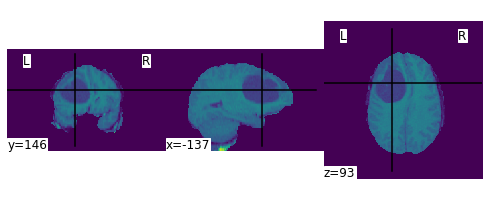

In [16]:
plotting.plot_img(image_nifti, [-137,146,93])

Plotting the t1 image with segmentation mask as overlay

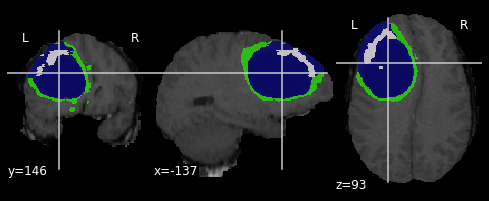

In [17]:
plotting.plot_roi(mask_nifti, image_nifti)

### There are few things going on here in the below step when we invoke the brats.load_data to generate csv.
-  Brats 2018 typical data sample is in the following format :
!ls /home/ubuntu/BraTs/data/LGG/Brats18_TCIA10_490_1/
The following are MR t1, t2, t1ce and flair images
Brats18_TCIA10_490_1_flair.nii.gz  
Brats18_TCIA10_490_1_t1ce.nii.gz
Brats18_TCIA10_490_1_t2.nii.gz
Brats18_TCIA10_490_1_t1.nii.gz

The following is the segementation ground truth , it has 3 labels (1,2,3) for  representing whole_tumor, tumor_core, enhanced_tumor. 
Brats18_TCIA10_490_1_seg.nii.gz   

The 'image' column consists of samples which are of dimension 4x240x240x155  . '4' represents the 4 types of MR images listed above. 
The 'mask' column consists of samples which are of dimension  240x240x155. 

'image' samples are run through simple itk's N4BiasFieldCorrection as it is standard step for bias correction.<br>
'image' samples are cropped to non-zero regions. This step is carreid out for 'mask' samples as well.<br>
'image' samples are reordered to RAS. 'mask' samples are reordered to RAS space as well.
'image' samples are resampled to new size having equal height,width,depth. This step is carried out for 'maks' samples  as well.<br>
Mean and std are calculated across the BraTs 2018 distribution.<br>
'image' samples are processed with (x-mean)/std  step.<br>



In [53]:
train_csv, val_csv, path = brats.load_data(path_brats='/home/ubuntu/BraTs', 
                                               resized_img_shape=(128,128,128), bias_correction=True)

In [8]:
df =pd.read_csv(train_csv)
df.head()

,mod_img,seg_mask
0,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA13...,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA13...
1,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA10...,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA10...
2,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA09...,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA09...
3,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA10...,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA10...
4,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA10...,/home/ubuntu/BraTs/preprocessed/Brats18_TCIA10...


Displaying the above sample, after the preprocess step .

In [18]:
image_pre_nifti = nib.load( os.path.join(path_brats,'preprocessed', 'Brats18_TCIA10_490_1_mod.nii.gz'))
mask_pre_nifti = nib.load(os.path.join(path_brats,'preprocessed', 'Brats18_TCIA10_490_1_seg.nii.gz'))
affine = np.eye(4)
new_spacing = np.array([1.66666667 ,1.66666667 ,1.07638889], dtype=np.float32)  
np.fill_diagonal(a=affine,val=new_spacing)
image_pre_t1_nifti = nib.Nifti1Image(image_pre_nifti.get_data()[0], affine=affine)   
mask_pre_t1_nifti = nib.Nifti1Image(mask_pre_nifti.get_data()[0], affine=affine)

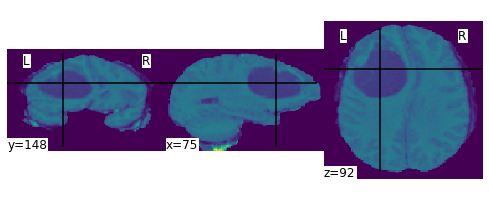

In [49]:
plotting.plot_img(image_pre_t1_nifti, [75,148, 92])

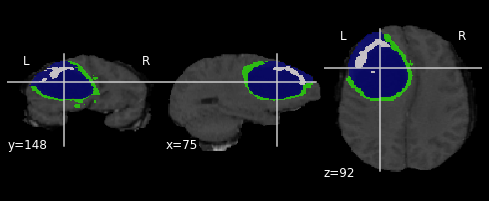

In [20]:
plotting.plot_roi(mask_pre_t1_nifti, image_pre_t1_nifti)

### RecordWriter Step
Reads the train csv and validation csv having nifti image paths.<br>
RecordWriter leverages NIBImageReader class to read nifti images.<br>


In [54]:
class NIBImageReader(NumpyOp):
    """Class for reading Nifti images
    Args:
        parent_path (str): Parent path that will be added on given path
    """
    def __init__(self, inputs=None, outputs=None, mode=None, parent_path="", grey_scale=False):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.parent_path = parent_path

    def forward(self, path, state):
        """Reads numpy array from image path
        Args:
            path: path of the image
            state: A dictionary containing background information such as 'mode'
        Returns:
           Image as numpy array
        """
        path = os.path.normpath(os.path.join(self.parent_path, path))
        data = nib.load(path)
        return data.get_data()
    

writer = fe.RecordWriter(
        save_dir=os.path.join(path_brats, "tfrecords"),
        train_data= train_csv,
        validation_data= val_csv,
        ops=[
            NIBImageReader(inputs="mod_img", outputs="mod_img"),
            NIBImageReader(inputs="seg_mask", outputs="seg_mask")
            
        ],
        compression="GZIP",
        write_feature=[
            'mod_img', 'seg_mask'
        ])

### Pipeline Operations
RandomImagePatches generates  3D patches from the Image and Mask. The patch size is defined by patch_shape.<br>
The 'mask' samples are of dimension nxnxn ,  'mask' are translated into 3xnxnxn , one for each label i.e. for whole_tumor, tumor_core and enhanced_tumor. 

In [55]:
class RandomImagePatches(TensorOp):
    def __init__(self, inputs=None, outputs=None, mode=None, image_shape=(144,144,144),patch_shape=(64,64,64),
                 patch_start_offset=16):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.nlabels = 3
        self.labels = [1,2,4]
        self.image_shape = tf.constant(image_shape, dtype=tf.dtypes.int32)
        self.patch_start_offset = tf.constant(patch_start_offset, dtype=tf.dtypes.int32)
        self.patch_shape = tf.constant( patch_shape, dtype=tf.dtypes.int32)
        self.modality_images, self.seg_mask = None, None
        
        
    def handle_padding_case(self, patch):
        pad_before = tf.where(patch < 0 , tf.abs(patch),0)
        pad_after = tf.where( (patch+ self.patch_shape) > self.image_shape, 
                             tf.abs( (patch + self.patch_shape) - self.image_shape), 0)
        padding = tf.stack( [pad_before, pad_after] , axis=1)
        no_padding = [[0,0]] # no padding in the batch dimension and the next dimention 
        padding = tf.concat([no_padding, padding], axis=0)
        data_pad = tf.pad(self.modality_images, padding, mode='CONSTANT', constant_values=0)
        truth_pad = tf.pad(self.segmask_multi_class, padding, mode='CONSTANT', constant_values=0)
        patch = patch + pad_before   
        data_patch = data_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
            patch[2]:patch[2]+self.patch_shape[2]]
        truth_patch = truth_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
           patch[2]:patch[2]+self.patch_shape[2]]
        return data_patch, truth_patch
            
    def handle_nopaddding_case(self, patch):
        data_pad = self.modality_images
        truth_pad = self.segmask_multi_class
        data_patch = data_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
            patch[2]:patch[2]+self.patch_shape[2]]
        truth_patch = truth_pad[..., patch[0]:patch[0]+self.patch_shape[0], patch[1]:patch[1]+self.patch_shape[1],
            patch[2]:patch[2]+self.patch_shape[2]]
        return data_patch, truth_patch
            
    def get_image_patch(self, patch):
        cond1 = tf.reduce_any(patch < 0 )
        cond2 = tf.reduce_any( patch + self.patch_shape > self.image_shape)
        cond = tf.logical_or(cond1,cond2)
        data_patch, truth_patch = tf.cond(cond,lambda: self.handle_padding_case(patch), 
                                          lambda:self.handle_nopaddding_case(patch))
        return data_patch, truth_patch
        
    def forward(self, data, state):
        self.modality_images, self.seg_mask = data
        new_shape = [self.nlabels]+ list(self.seg_mask.shape[-3:])

        cls_1 = tf.where(self.seg_mask[0]==self.labels[0],1,0)
        cls_2 = tf.where(self.seg_mask[0]==self.labels[1],1,0)
        cls_4 = tf.where(self.seg_mask[0]==self.labels[2],1,0)
        self.segmask_multi_class = tf.stack([cls_1,cls_2,cls_4])
        
        # We randomly select the start of patches 
        random_start_offset = tf.negative(tf.random.uniform(shape=(3,),minval=0,maxval=self.patch_start_offset+1, 
                                                            dtype=tf.dtypes.int32))

        start = random_start_offset
        stop = self.image_shape + random_start_offset
        step = self.patch_shape
        x,y,z = tf.meshgrid( tf.range(start[0],stop[0],step[0]),  tf.range(start[1],stop[1],step[1]), 
                                        tf.range(start[2],stop[2],step[2]),indexing='ij')
        patches = tf.stack([x,y,z],axis=0)
        patches = tf.transpose(tf.reshape(patches,(3,-1)))
        
        data_stack,truth_stack = tf.map_fn(self.get_image_patch,patches, 
                                           dtype=(tf.dtypes.float32, tf.dtypes.int32), back_prop=False)
        mask = tf.map_fn(lambda tr: tf.reduce_any(tf.not_equal(tr,0)) , truth_stack, 
                 dtype=tf.bool, back_prop=False)
        data_stack = tf.boolean_mask(data_stack, mask)
        truth_stack = tf.boolean_mask(truth_stack, mask)  

        return data_stack, truth_stack
    

Pipeline engages Augmentation3D operation. The patches have equal height, width and depth, one may utilize various isometries of a cube for augmentation.
https://en.wikipedia.org/wiki/Octahedral_symmetry#The_isometries_of_the_cube

In [11]:
class SplitMaskLabelwise(TensorOp):
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.nlabels = 3
        self.labels = [1,2,4]
    def forward(self, data, state):
        seg_mask = data
        cls_1 = tf.where(seg_mask[0]==self.labels[0],1,0)
        cls_2 = tf.where(seg_mask[0]==self.labels[1],1,0)
        cls_4 = tf.where(seg_mask[0]==self.labels[2],1,0)
        segmask_multi_label = tf.stack([cls_1,cls_2,cls_4])
        return segmask_multi_label
        
# pipeline = fe.Pipeline(data=writer,
#                        batch_size=2,
#                        ops=[Augmentation3D(inputs=("mod_img","seg_mask"), outputs=("mod_img", "seg_mask")) , 
#                            RandomImagePatches(inputs=("mod_img", "seg_mask"), outputs=("mod_img", "seg_mask"),
#                                 image_shape=(128,128,128),patch_shape=(64,64,64),patch_start_offset=0)],
#                        expand_dims=True)
pipeline = fe.Pipeline(data=writer,
                       batch_size=1,
                        ops=[ SplitMaskLabelwise(inputs="seg_mask", outputs="seg_mask") ,
                             Augmentation3D(inputs=("mod_img","seg_mask"), outputs=("mod_img", "seg_mask"),mode='train')])

Generating batches from pipeline api show_results

In [13]:
sample_batch = pipeline.show_results()

FastEstimator: Saving tfrecord to /home/ubuntu/BraTs/tfrecords
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 3.4%, Speed: 3.60 record/sec
FastEstimator: Converting Train TFRecords 6.9%, Speed: 3.65 record/sec
FastEstimator: Converting Train TFRecords 10.3%, Speed: 3.67 record/sec
FastEstimator: Converting Train TFRecords 13.8%, Speed: 3.70 record/sec
FastEstimator: Converting Train TFRecords 17.2%, Speed: 3.67 record/sec
FastEstimator: Converting Train TFRecords 20.7%, Speed: 3.68 record/sec
FastEstimator: Converting Train TFRecords 24.1%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 27.6%, Speed: 3.89 record/sec
FastEstimator: Converting Train TFRecords 31.0%, Speed: 3.84 record/sec
FastEstimator: Converting Train TFRecords 34.5%, Speed: 3.76 record/sec
FastEstimator: Converting Train TFRecords 37.9%, Speed: 3.76 record/sec
FastEstimator: Converting Train TFRecords 41.4%, Speed: 3.73 record/sec
Fast

In [25]:
sample_batch[0]['mod_img'].shape , sample_batch[0]['seg_mask'].shape

(TensorShape([1, 4, 128, 128, 128]), TensorShape([1, 3, 128, 128, 128]))

###  View the 'image' and 'mask' sample after all the processing in the pipeline stage.

In [53]:
image_prep_aug = sample_batch[0]['mod_img'][0]
image_prep_aug = image_prep_aug.numpy()

mask_prep_aug = sample_batch[0]['seg_mask'][0]
mask_prep_aug = mask_prep_aug.numpy()

affine = np.eye(4)
new_spacing = np.array([1.0, 1.0, 1.0], dtype=np.float32)
np.fill_diagonal(a=affine,val=new_spacing)
image_patch = nib.Nifti1Image(image_prep_aug[0], affine=affine)
mask_patch = nib.Nifti1Image(mask_prep_aug[0], affine=affine)

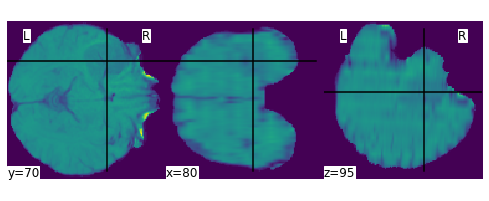

In [56]:
plotting.plot_img(image_patch, [80,70,95])

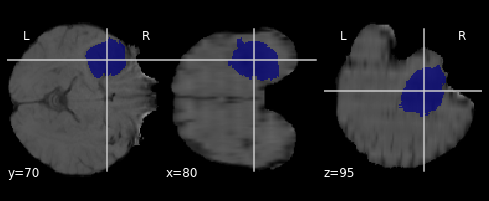

In [55]:
plotting.plot_roi(mask_patch, image_patch)

### Creation of the Network

![network](./Figure/Isensee_network.jpeg)

In [56]:
import tensorflow_addons as tfa

import tensorflow
from tensorflow.python.keras.layers import Activation, BatchNormalization, Conv3D, Conv3DTranspose, Input \
, SpatialDropout3D, UpSampling3D, concatenate, LeakyReLU, ReLU, Add
from tensorflow.python.keras.models import Model
from tensorflow_addons.layers import InstanceNormalization

def convolution_module(layer, filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same'
                      ,instance_norm=False, batch_norm=False, activation=None):
    layer = Conv3D(filters=filters,kernel_size=kernel_size, strides=strides, padding=padding,
          data_format='channels_first')(layer)
    if instance_norm == True:
        layer = InstanceNormalization(axis=1)(layer)
    if batch_norm == True:
        layer = BatchNormalization(axis=1)(layer)
    if activation is None:
        layer = ReLU()(layer)
    else:
        layer = activation()(layer)
    return layer
        
def context_module(layer, filters, dropout):
    layer = convolution_module(layer, filters, activation=LeakyReLU, instance_norm=True)
    layer = SpatialDropout3D(rate=dropout, data_format='channels_first')(layer)
    layer = convolution_module(layer, filters, activation=LeakyReLU, instance_norm=True)
    return layer
    
def upsampling_module(layer, filters):
    upsample = UpSampling3D(size=(2,2,2), data_format='channels_first')(layer)
    upsample_conv = convolution_module(upsample, filters, activation=LeakyReLU, instance_norm=True)
    return upsample_conv
    
def localization_module(layer, filters):
    layer = convolution_module(layer, filters, activation=LeakyReLU, instance_norm=True)
    layer = convolution_module(layer, filters, activation=LeakyReLU, kernel_size=(1,1,1), instance_norm=True)
    return layer
    
def UNet3D_Isensee(input_shape=(4, 128,128,128), nchannels=(16, 32, 64, 128, 256), n_labels=3,
           activation='sigmoid', dr=0.3, n_segmentation_level=3, lr=5e-4):
    inputs = Input(input_shape)
    current_layer = inputs
    downsample_level = []
    segmentation_level = []
    for idx, filters in enumerate(nchannels):
        if idx == 0 :
            in_conv = convolution_module(current_layer, filters, activation=LeakyReLU, instance_norm=True)
        else:
            in_conv = convolution_module(current_layer, filters, activation=LeakyReLU, strides=(2,2,2), instance_norm=True)
        context_layer = context_module(in_conv, filters, dropout=0.3)
        add_layer = Add()([in_conv ,context_layer])
        downsample_level.append(add_layer)
        current_layer = add_layer
    
    for idx,filters in  reversed(list(enumerate(nchannels[:-1:]))):
        upsample_conv = upsampling_module(current_layer, filters)
        current_layer =  concatenate([upsample_conv, downsample_level[idx]], axis=1)
        localization = localization_module(current_layer, filters)
        current_layer = localization
        if idx < n_segmentation_level:
            layer = Conv3D(n_labels, kernel_size=(1,1,1), data_format='channels_first')(localization)
            segmentation_level.append(layer)
            
    output_layer = None
    for idx in range(len(segmentation_level)):
        if output_layer is None:
            output_layer = segmentation_level[idx]
        else:
            output_layer = Add()([output_layer, segmentation_level[idx]])
        if idx != len(segmentation_level)-1:    
            output_layer = UpSampling3D(size=(2,2,2), data_format='channels_first')(output_layer)
            
    act = Activation(activation)(output_layer)
    model = Model(inputs=inputs, outputs=act)
    return model

### WeightedDiceLoss 

In [15]:
# class DiceLoss(Loss):
#     def forward(self, data, state):
#         y_true, y_pred = data
#         y_true = tf.cast(y_true, dtype=tf.float32)
#         smooth=1.
#         batch_size = state["batch_size"]
#         y_true_f = tf.reshape(y_true, (batch_size,-1))
#         y_pred_f = tf.reshape(y_pred, (batch_size,-1))
#         intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
#         loss = (-2. * intersection + smooth) / (tf.reduce_sum(y_true_f, axis=1) + 
#                                                tf.reduce_sum(y_pred_f, axis=1) + smooth)
#         return loss
        
class WeightedDiceLoss(Loss):
    def forward(self, data, state):
        y_true, y_pred = data
        smooth=0.00001
        y_true = tf.cast(y_true, dtype=tf.dtypes.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[-3,-2,-1])
        union = tf.reduce_sum(y_true, axis=[-3,-2,-1]) + tf.reduce_sum(y_pred, axis=[-3,-2,-1])
        loss = -2.*(intersection + smooth/2) / (union + smooth)
        loss = tf.reduce_mean(loss, axis=1)
        return loss
    

### Creation of the network

In [ ]:
model_unet3d_is = fe.build(model_def=lambda: UNet3D_Isensee(input_shape=(4, 128,128, 128)),
                         model_name="brats_unet3d_is",
                         optimizer=tf.optimizers.Adam(learning_rate=5e-4),
                         loss_name="wdice_loss")


network = fe.Network(ops=[
    ModelOp(inputs="mod_img", model=model_unet3d_is, outputs="pred_seg_mask"),
    WeightedDiceLoss(inputs=("seg_mask", "pred_seg_mask"),
               outputs=("wdice_loss"))])

### Creation of the estimator

In [16]:
# prepare estimator
model_dir = path_brats
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    steps_per_epoch= 228,
    epochs=500,
    traces=[ModelSaver(model_name="brats_unet3d_is", save_dir=model_dir, save_best=True),
           LRController(model_name="brats_unet3d_is",reduce_patience=10, reduce_factor=0.5, 
                        reduce_on_eval=True, min_lr=1e-07)],
    log_steps=228)

### Training begins

In [19]:
estimator.fit()


## Inference

In [46]:
sample_val = pipeline.show_results(mode='eval')

FastEstimator: Reading non-empty directory: /home/ubuntu/BraTs/tfrecords
FastEstimator: Found 228 examples for train in /home/ubuntu/BraTs/tfrecords/train_summary0.json
FastEstimator: Found 57 examples for eval in /home/ubuntu/BraTs/tfrecords/eval_summary0.json


In [47]:
model_unet3d_is.load_weights('/home/ubuntu/BraTs/brats_unet3d_is_best_wdice_loss.h5')

In [48]:
sample_batch = sample_val[0]['mod_img']
batch_val_img = sample_batch.numpy()
batch_val_img_item = sample_batch.numpy()[0]
batch_pred = model_unet3d_is(sample_batch)
batch_pred_item = batch_pred.numpy()[0]
batch_truth = sample_val[0]['seg_mask']
batch_truth_item = batch_truth.numpy()[0]

In [49]:
affine = np.eye(4)
new_spacing = np.array([1.0 ,1.0 ,1.0], dtype=np.float32)
np.fill_diagonal(a=affine,val=new_spacing)
nifti_val_img = nib.Nifti1Image(batch_val_img_item[0], affine=affine)


In [50]:
affine = np.eye(4)
new_spacing = np.array([1.0 ,1.0 ,1.0], dtype=np.float32)
np.fill_diagonal(a=affine,val=new_spacing)
nifti_pred_img = nib.Nifti1Image(batch_pred_item[2], affine=affine)
nifti_truth_img = nib.Nifti1Image(batch_truth_item[2], affine=affine)

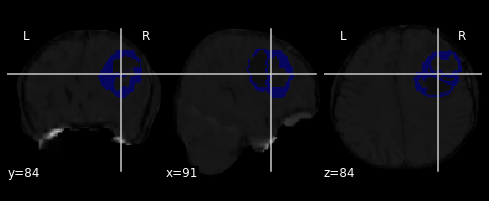

In [51]:
plotting.plot_roi(nifti_truth_img, nifti_val_img)

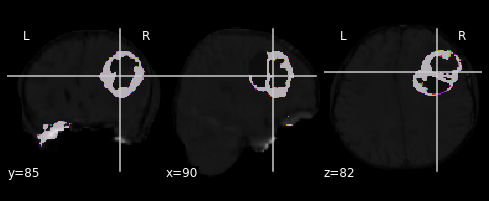

In [52]:
plotting.plot_roi(nifti_pred_img, nifti_val_img)

In [45]:
# pipeline = fe.Pipeline(data=writer,
#                        batch_size=100,
#                        ops=[ RandomImagePatches(inputs=("mod_img", "seg_mask"), outputs=("mod_img", "seg_mask"))],
#                        expand_dims=True)
# pipeline.prepare()
# ds_iter = pipeline.dataset_schedule["train"].get_current_value(0)
# # batch = next(ds_iter)
# # print(batch['mod_img'])
# for ds in ds_iter:
#     print(ds['seg_mask'].shape)